close                1.000000
open                 0.812649
high                 0.786225
liquidity_ratio      0.758844
low                  0.752075
beta_indicator       0.732012
oscillator_value     0.681253
risk_premium         0.575406
market_sentiment     0.498382
alpha_signal         0.380283
technical_score      0.345026
volatility_factor    0.307969
trend_strength       0.287093
momentum_index       0.264872
quant_index          0.061985
index                0.001865
volume              -0.130450
Name: close, dtype: float64
                      open      high  liquidity_ratio       low  \
open              1.000000  0.643042         0.623565  0.616715   
high              0.643042  1.000000         0.601839  0.595409   
liquidity_ratio   0.623565  0.601839         1.000000  0.575422   
low               0.616715  0.595409         0.575422  1.000000   
beta_indicator    0.599844  0.581059         0.559953  0.554462   
oscillator_value  0.557724  0.538653         0.521479  0.519

C:\Users\Raj\AppData\Local\Temp\ipykernel_16864\482535734.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[features + ['close']] = data[features + ['close']].fillna(method='ffill')


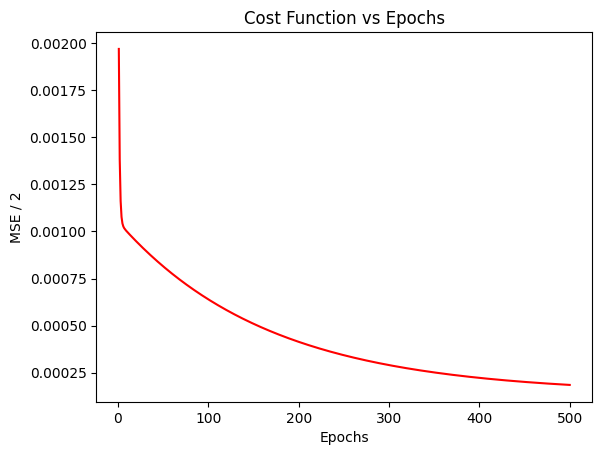

      Actual  Predicted
0  95.610001  88.984592
1  27.410000  59.936643
2  25.230000  60.839043
3  30.000000 -12.513292
4  68.480003  51.766552
5  43.209999  54.901717
6  64.430000  94.760637
7  39.849998  69.290516
8   7.075000  33.106544
9  72.010002  52.690822
Root Mean Squared Error (RMSE): 30.31

--- Test Data Predictions ---
       Actual  Predicted
0   42.099998  48.955568
1  102.639999  63.093902
2   46.150002  84.061331
3   51.862000  83.377615
4   40.790001  77.509250
5   25.350000  27.664329
6   22.580000  73.130154
7   52.180000  94.895623
8   43.126079   3.804350
9  104.220001  98.190369

Test RMSE: 35.89


In [521]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(r"D:\OneDrive\Desktop\First Semester\Manas\Data\train.csv")
#feature selection
numeric_data = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_data.corr()
target_corr = corr_matrix['close'].sort_values(ascending=False) 
print(target_corr)
#feature scaling
features=["open","high","liquidity_ratio","low","beta_indicator","oscillator_value","risk_premium","market_sentiment"]
corr_1=data[features].corr()
print(corr_1)

# Drop rows with NaN in selected features or target
data[features + ['close']] = data[features + ['close']].fillna(method='ffill')
x_scaled_list = []
for feature in features:
    x = data[feature]
    x_scaled = (x - x.min()) / (x.max() - x.min())
    x_scaled_list.append(x_scaled)
x_dash = np.array(x_scaled_list).T

y = data['close']
y_scaled = (y - y.min()) / (y.max() - y.min())
y_scaled_np = np.array(y_scaled)

m_dash = np.zeros(len(features))
b = 0.0
L = 0.3#38.07,41.94
epochs = 500
mse_list = []

for i in range(epochs):
    y_pred = np.dot(x_dash, m_dash) + b
    mse = np.mean((y_pred - y_scaled_np) ** 2) / 2  # MSE / 2
    mse_list.append(mse)
    D_m = np.mean((y_pred - y_scaled_np)[:, None] * x_dash, axis=0)
    D_b = np.mean(y_pred - y_scaled_np)
    m_dash -= L * D_m
    b -= L * D_b
plt.plot(range(1, epochs+1), mse_list, color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE / 2")
plt.title("Cost Function vs Epochs")
plt.show()

# Predict for input
y_pred_final = np.dot(x_dash, m_dash) + b
y_pred_final_real = y_pred_final * (y.max() - y.min()) + y.min()  # rescale

comparison = pd.DataFrame({'Actual': y[:10], 'Predicted': y_pred_final_real[:10]})

print(comparison)

# RMSE
y_true = y.to_numpy()
rmse = np.sqrt(np.mean((y_true - y_pred_final_real) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- TRAINING PHASE (already done above) ---

# Now let's move to TEST PHASE
# ----------------------------------------------------

# Load your test dataset
test_data = pd.read_csv(r"D:\OneDrive\Desktop\First Semester\Manas\Data\test.csv")

# Drop rows with missing values in required columns
test_data = test_data.dropna(subset=features + ['close']).reset_index(drop=True)

# Apply the SAME scaling method used for training
x_test_scaled_list = []
for feature in features:
    x_test = test_data[feature]
    # Important: Use TRAINING data’s min and max for scaling, not test’s own
    train_min = data[feature].min()
    train_max = data[feature].max()
    x_test_scaled = (x_test - train_min) / (train_max - train_min)
    x_test_scaled_list.append(x_test_scaled)

x_test_dash = np.array(x_test_scaled_list).T

# Scale target (close) for comparison (optional)
y_test = test_data['close']
y_test_scaled = (y_test - y_test.min()) / (y_test.max() - y_test.min())

# Predict using trained model
y_test_pred_scaled = np.dot(x_test_dash, m_dash) + b

# Rescale predictions back to real values
y_test_pred_real = y_test_pred_scaled * (y_test.max() - y_test.min()) + y_test.min()

# Compare first few results
comparison_test = pd.DataFrame({
    'Actual': y_test[:10].values,
    'Predicted': y_test_pred_real[:10]
})
print("\n--- Test Data Predictions ---")
print(comparison_test)

# Calculate RMSE for test data
rmse_test = np.sqrt(np.mean((y_test - y_test_pred_real) ** 2))
print(f"\nTest RMSE: {rmse_test:.2f}")
